# Harmonizing `Response`s with JAX

In [2]:
from jax import jit
from gcdyn import responses, bdms, mutators, model, model_old
from jaxopt import GradientDescent, ScipyBoundedMinimize
from jax.tree_util import register_pytree_node_class
import matplotlib.pyplot as plt
import numpy as np
from ete3.coretype.tree import TreeError

responses.init_numpy(use_jax=True)

In [3]:
def plot_response(response):
    X = np.arange(-10, 10, 0.5)
    plt.plot(X, response.f(X))
    plt.ylabel("Birth rate")
    plt.show()

def evolve_trees(num_trees, init_x = 0, **evolve_kwargs):
    trees = []
    seed = evolve_kwargs.pop("seed", None)

    for _ in range(num_trees):
        while True:
            try:
                tree = bdms.TreeNode(x = init_x)
                tree.evolve(seed = seed, **evolve_kwargs)
                trees.append(tree)
                break

            except TreeError: # not enough survivors
                seed = seed + 1 if seed is not None else None

        seed = seed + 1 if seed is not None else None

    print("Average of", sum(len(list(tree.traverse())) for tree in trees) / len(trees), "nodes per tree, over", len(trees), "trees")

    return trees

## Understanding object flattening

In [4]:
resp = responses.ConstantResponse(-2.)
flat = resp.tree_flatten()

print(resp)
print(flat)
print(responses.ConstantResponse().tree_unflatten(flat[1], flat[0]))

ConstantResponse(value=-2.0)
((-2.0,), ('value',))
ConstantResponse(value=-2.0)


## Gradient descent

In [5]:
register_pytree_node_class(responses.ConstantResponse)

@jit
def objective(resp):
    x = resp.f(1)
    return (x - 5)**2

objective(resp)

DeviceArray(49., dtype=float32, weak_type=True)

In [6]:
optimizer = GradientDescent(fun=objective)
optimizer.run(
    responses.ConstantResponse(-2.)
)

OptStep(params=ConstantResponse(value=5.0), state=ProxGradState(iter_num=DeviceArray(1, dtype=int32, weak_type=True), stepsize=DeviceArray(1., dtype=float32, weak_type=True), error=DeviceArray(0., dtype=float32), aux=None, velocity=ConstantResponse(value=5.0), t=DeviceArray(1.618034, dtype=float32, weak_type=True)))

## Bounded optimization

Note that the bounds used in the optimizer call must be numerical and not `Response` objects, and I don't exactly know why

In [7]:
optimizer = ScipyBoundedMinimize(fun=objective)
optimizer.run(
    responses.ConstantResponse(-2.),
    (-10, 10)
)

OptStep(params=ConstantResponse(value=5.0), state=ScipyMinimizeInfo(fun_val=DeviceArray(0., dtype=float32, weak_type=True), success=True, status=0, iter_num=2))

## BDMS inference

In [22]:
birth_rate = responses.SigmoidResponse(1., 0., 2., 0.)
death_rate = responses.ConstantResponse(1)
mutation_rate = responses.ConstantResponse(1)
sampling_probability = 1

mutator = mutators.GaussianMutator(-1, 1)

Average of 960.0 nodes per tree, over 1 trees

      /- /-4
     |
     |                        /- /-197
     |               /- /- /-|
     |              |        |   /- /- /-468
     |              |         \-|
     |              |           |   /-222
     |            /-|            \-|
     |           |  |               \-223
     |           |  |
     |           |  |      /- /- /- /- /-45
     |           |   \- /-|
     |           |         \-19
     |           |
     |           |               /- /- /-106
     |           |              |
     |           |              |                  /-205
     |           |              |                 |
     |           |              |                 |                        /-473
     |           |              |                 |                       |
     |           |              |                 |                     /-|         /- /-723
     |           |              |                 |                    |  |     

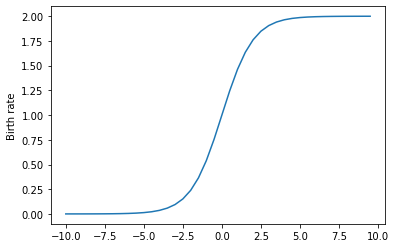

In [32]:
responses.init_numpy(False) # jax numpy breaks evolve for some reason

trees = evolve_trees(1, 
    t = 9,
    birth_rate = birth_rate,
    death_rate = death_rate,
    mutation_rate = mutation_rate,
    mutator = mutator,
    seed = 10
)

for tree in trees:
    tree.sample_survivors(p = sampling_probability, seed = 0)

print(trees[0])
plot_response(birth_rate)

In [33]:
responses.init_numpy(True)
mod = model.BdmsModel(
    trees = trees,
    death_rate = death_rate,
    mutation_rate = mutation_rate,
    mutator = mutator,
    sampling_probability = sampling_probability
)

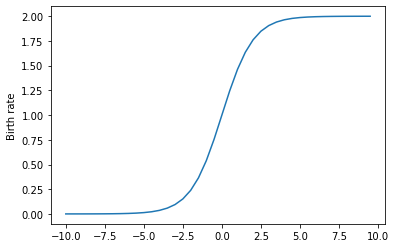

In [34]:
initial_birth_rate = responses.SigmoidResponse(1., 0., 2., 0.)
plot_response(initial_birth_rate)

In [35]:
result = mod.fit(init_value=initial_birth_rate)

result

OptStep(params=SigmoidResponse(xscale=0.875422477722168, xshift=1.4229280948638916, yscale=4.037017822265625, yshift=0.0), state=ScipyMinimizeInfo(fun_val=DeviceArray(1128.9486, dtype=float32, weak_type=True), success=True, status=0, iter_num=16))

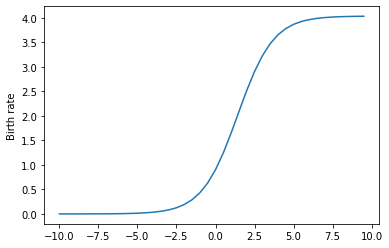

In [36]:
plot_response(result.params)

In [37]:
# JIT works, this runs faster
mod.fit(init_value=initial_birth_rate)

OptStep(params=SigmoidResponse(xscale=0.875422477722168, xshift=1.4229280948638916, yscale=4.037017822265625, yshift=0.0), state=ScipyMinimizeInfo(fun_val=DeviceArray(1128.9486, dtype=float32, weak_type=True), success=True, status=0, iter_num=16))

Convergence seems off...